# Gerando Dados p/ Exemplo bidimensional simples

$y = x + 2 + \eta$

In [1]:
import numpy as np

X = np.arange(-5, 5, 0.05)

nb_samples = len(X)

Y = X + 2
Y += np.random.normal(0.0, 0.5, size=nb_samples)

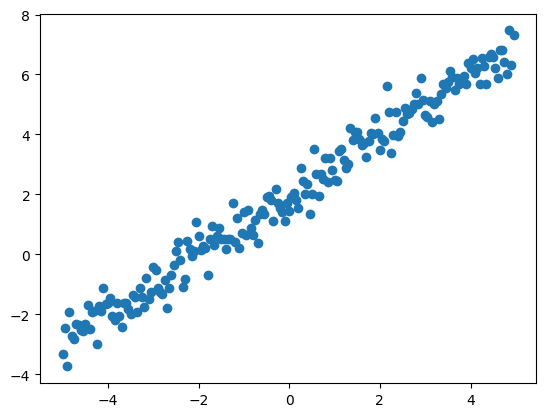

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X, Y)
plt.show()

### Função de Perda

$ 𝐿=\frac{1}{2} \sum_{𝑖=1}^m (\alpha + \beta x_i + y_i)^2$


### Gradiente
$\Biggl\{
\begin{array}{ll}
 \frac{\delta L}{\delta \alpha} \sum_{𝑖=1}^n (\alpha + \beta x_i - y_i) = 0\\
 \frac{\delta L}{\delta \beta} \sum_{𝑖=1}^n (\alpha + \beta x_i - y_i)x_i = 0
\end{array}$



In [3]:
def loss(v):
   e = 0.0
   for i in range(nb_samples):
      e += np.square(v[0] + v[1]*X[i] - Y[i])
   return 0.5 * e


def gradient(v):
   g = np.zeros(shape=2)
   for i in range(nb_samples):
      g[0] += (v[0] + v[1]*X[i] - Y[i])
      g[1] += ((v[0] + v[1]*X[i] - Y[i]) * X[i])
   return g

### Minimizar

In [4]:
from scipy.optimize import minimize
res = minimize(fun=loss, x0=[0.0, 0.0], jac=gradient, method='L-BFGS-B')
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 20.72426343435246
        x: [ 2.007e+00  9.940e-01]
      nit: 6
      jac: [ 6.945e-05  2.398e-05]
     nfev: 7
     njev: 7
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [5]:
def predictY(X, alpha, beta):
    Ym = []
    for i in range(len(X)):
        Ym.append(beta * X[i] + alpha)
    return Ym

In [6]:
Ym = predictY(X, res.x[0], res.x[1])

from sklearn.metrics import r2_score
r2 = r2_score(Y,Ym)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9754465429496705


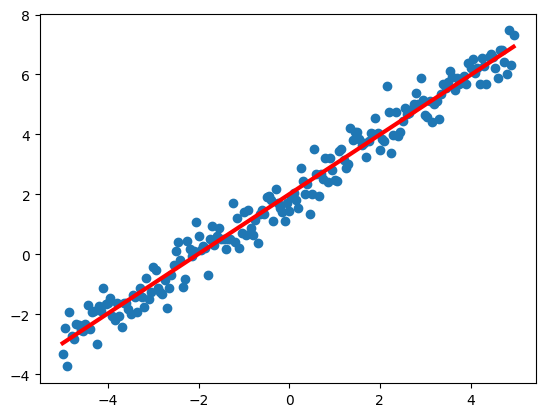

In [7]:
import matplotlib.pyplot as plt

alpha =  res.x[0]
beta = res.x[1]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

## Método Matricial

In [8]:
Xs = np.expand_dims(X, axis=1)
Ys = np.expand_dims(Y, axis=1)
Xs = np.concatenate((Xs, np.ones_like(Xs)), axis=1)

result = np.linalg.inv(np.dot(Xs.T, Xs)).dot(Xs.T).dot(Y)
print(result[1], result[0])
print('y = %2.f + %.2fx' % (result[1], result[0]))


2.0065669925317655 0.9939877147754843
y =  2 + 0.99x


In [9]:
result

array([0.99398771, 2.00656699])

In [10]:
Ym = predictY(X, result[1], result[0])

from sklearn.metrics import r2_score
r2 = r2_score(Y,Ym)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9754465429496849


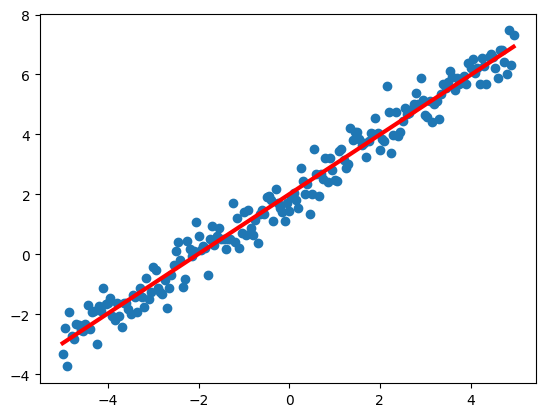

In [11]:
import matplotlib.pyplot as plt

alpha = result[1]
beta = result[0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

## Exemplo de Regressão

In [12]:
import pandas as pd  # doctest: +SKIP
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

boston={}
boston["data"] = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston["target"] = raw_df.values[1::2, 2]

In [13]:
print(boston["data"].shape)

print(boston["target"].shape)


(506, 13)
(506,)


In [14]:
def norma_l2(X):
    X = X - np.mean(X, axis=0)
    X = X / np.linalg.norm(X, axis=0)
    return X

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(boston["data"], boston["target"], test_size=0.3)

lr = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
reg = lr.fit(X_train, Y_train)


In [16]:
print(reg['linearregression'].coef_)
print(reg['linearregression'].intercept_)
print(reg.score(X_test, Y_test))


[-0.69241039  1.094836    0.23444951  0.53158214 -2.40339214  2.49377438
  0.11911471 -3.41504609  3.07608298 -2.30353596 -2.30076981  1.08620568
 -3.98617297]
42.29200003690221
0.7699502693568789


In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, boston["data"], boston["target"], cv=7, scoring='neg_mean_squared_error')
scores

array([ -11.30795492,  -10.94743251,  -32.12487323,  -33.57836799,
        -10.54825524, -149.57087382,  -12.93285837])

In [18]:
print(scores.mean())
print(scores.std())


-37.287230868353056
46.789556388019896


In [19]:
scores = cross_val_score(lr, boston["data"], boston["target"], cv=7, scoring='r2')
scores

array([ 0.6534446 ,  0.59631685,  0.67865382,  0.61193393,  0.51940514,
       -0.30577687,  0.4001835 ])

In [20]:
print(scores.mean())
print(scores.std())


0.4505944247136278
0.32066859895021543


## Variância Explicada

$EV = 1-\frac{Var[Y-\tilde{Y}]}{Var[Y]}$

In [21]:
print(cross_val_score(lr, boston["data"], boston["target"], cv=7, scoring='explained_variance'))

[ 0.66521666  0.62517506  0.71074827  0.61741337  0.57297245 -0.15926251
  0.49621415]


## Ridge Regression

In [22]:
from sklearn.linear_model import Ridge

lr = LinearRegression()
rg = Ridge(0.05)

lr_scores = cross_val_score(lr,  norma_l2(boston["data"]), boston["target"], cv=7)
print(lr_scores)
print(lr_scores.mean())


rg_scores = cross_val_score(rg,  norma_l2(boston["data"]), boston["target"], cv=7)
print(rg_scores)
print(rg_scores.mean())

[ 0.6534446   0.59631685  0.67865382  0.61193393  0.51940514 -0.30577687
  0.4001835 ]
0.45059442471362815
[ 0.72006099  0.6417548   0.66042987  0.61092785  0.56271438 -0.11567796
  0.47999145]
0.5086001970190458


In [23]:
from sklearn.linear_model import RidgeCV

rg = RidgeCV(alphas=(1.0, 0.1, 0.01, 0.05, 0.005, 0.0025, 0.001, 0.00025),cv=7)
rg.fit(norma_l2(boston["data"]), boston["target"])

print(rg.alpha_)

0.1


## Lasso Regression

In [24]:
from sklearn.linear_model import Lasso

ls = Lasso(alpha=0.01)

ls_scores = cross_val_score(ls, norma_l2(boston["data"]), boston["target"], cv=7)

print(ls_scores.mean())


0.4575355812078458


In [25]:
from sklearn.linear_model import LassoCV

rs = LassoCV(alphas=(1.0, 0.1, 0.01, 0.005, 0.0025, 0.001, 0.00025),cv=7)
rs.fit(norma_l2(boston["data"]), boston["target"])

print(rs.alpha_)

0.001


## ElasticNet Regression

In [26]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

en = ElasticNet(alpha=0.001, l1_ratio=0.8)
en_scores = cross_val_score(en, norma_l2(boston["data"]), boston["target"], cv=7)

print(en_scores.mean())

0.5184128742552574


In [27]:
encv = ElasticNetCV(alphas=(0.1, 0.01,0.05, 0.005, 0.0025, 0.001), l1_ratio=(0.1, 0.25, 0.5, 0.75, 0.8),cv=7)
encv.fit(norma_l2(boston["data"]), boston["target"])

print(encv.alpha_)
print(encv.l1_ratio_)


0.001
0.5


## RANSAC

In [28]:
import numpy as np

X1 = np.arange(-5, 2.5, 0.05)

X2 = np.arange(2.5, 5, 0.05)

X = np.concatenate((X1, X2))

Y1 = X1 + 2
Y1 += np.random.normal(0.0, 0.5, size=len(X1))

Y2 = X2 + 10
Y2 += np.random.normal(0.0, 1, size=len(X2))

Y = np.concatenate((Y1, Y2))

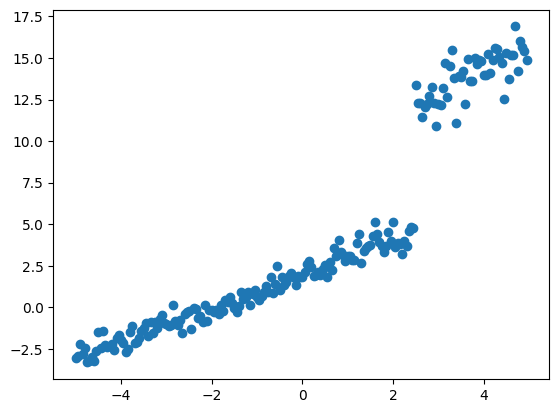

In [29]:
import matplotlib.pyplot as plt

plt.scatter(X, Y)
plt.show()

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X.reshape((-1, 1)), Y.reshape((-1, 1)))

print(lr.intercept_)

print(lr.coef_)


[4.0732374]
[[1.93722992]]


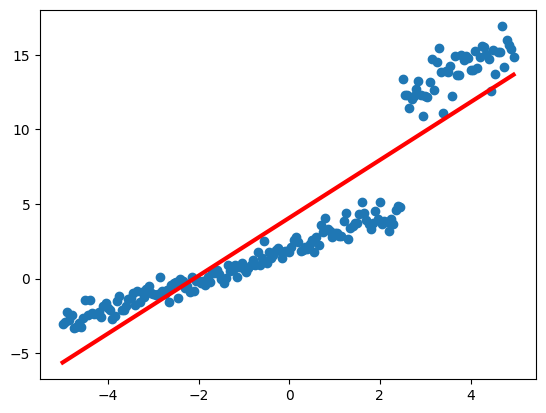

In [31]:
import matplotlib.pyplot as plt

alpha =  lr.intercept_[0]
beta = lr.coef_[0][0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

In [32]:
from sklearn.linear_model import RANSACRegressor

rs = RANSACRegressor(lr)
rs.fit(X.reshape((-1, 1)), Y.reshape((-1, 1)))

print(rs.estimator_.intercept_)
print(rs.estimator_.coef_)


[2.02438175]
[[1.01963703]]


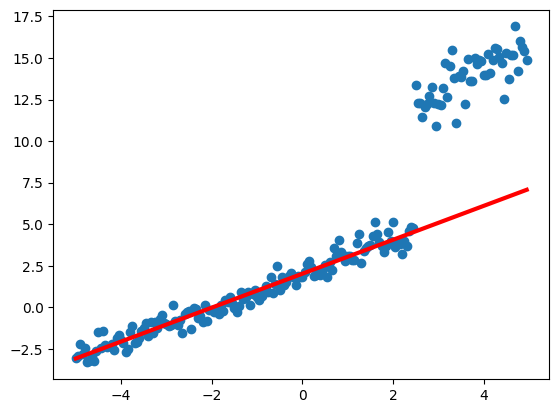

In [33]:
import matplotlib.pyplot as plt

alpha =  rs.estimator_.intercept_[0]
beta = rs.estimator_.coef_[0][0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

## Huber Regression

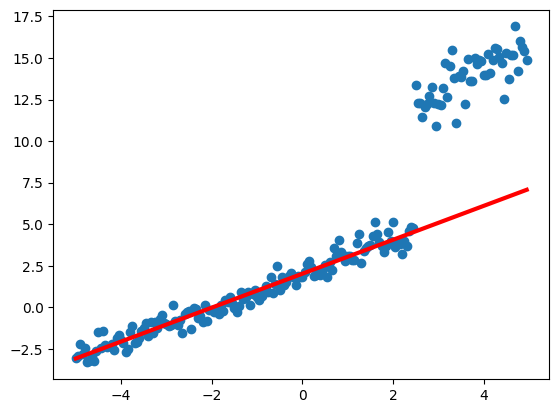

In [34]:
import matplotlib.pyplot as plt

alpha =  rs.estimator_.intercept_[0]
beta = rs.estimator_.coef_[0][0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

In [35]:
import numpy as np
from random import random, randint

X = np.arange(-5, 5, 0.05)

Y = X + 2

Y += np.random.normal(0.0, 0.5, size=len(X))

for i in range(0,len(Y)):
    if random() > 0.7:
        Y[i] += randint(0,10)

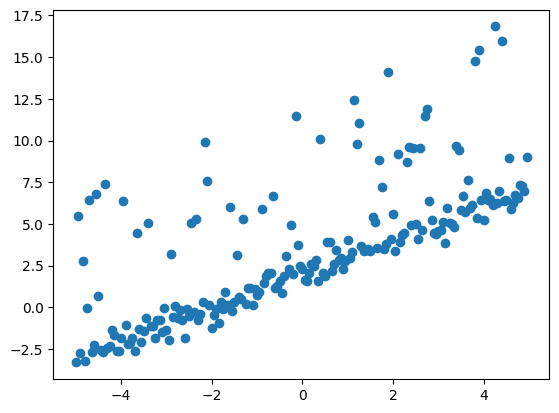

In [36]:
import matplotlib.pyplot as plt

plt.scatter(X, Y)
plt.show()

In [37]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X.reshape((-1, 1)), Y.reshape((-1, 1)))

print(lr.intercept_)

print(lr.coef_)


[3.45177575]
[[1.00146634]]


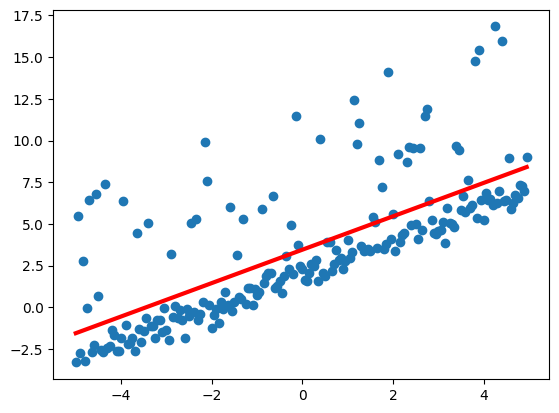

In [38]:
import matplotlib.pyplot as plt

alpha =  lr.intercept_[0]
beta = lr.coef_[0][0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

#### Vamos comparar o resultado com o Ransac

In [39]:
from sklearn.linear_model import RANSACRegressor

rs = RANSACRegressor(lr)
rs.fit(X.reshape((-1, 1)), Y.reshape((-1, 1)))

print(rs.estimator_.intercept_)
print(rs.estimator_.coef_)


[2.23899232]
[[1.07079342]]


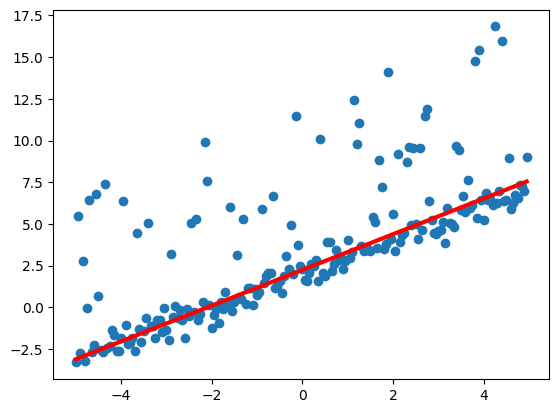

In [40]:
import matplotlib.pyplot as plt

alpha =  rs.estimator_.intercept_[0]
beta = rs.estimator_.coef_[0][0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

In [41]:
#### ... mas e se eu modificar o parâmetro tH do Huber e definir um limite?

In [42]:
from sklearn.linear_model import HuberRegressor

hr = HuberRegressor(epsilon=1.25) # epsilon do sklearn é o tH
hr.fit(X.reshape(-1, 1), Y)

print(hr.intercept_)
print(hr.coef_)


2.2749307711458715
[1.01639475]


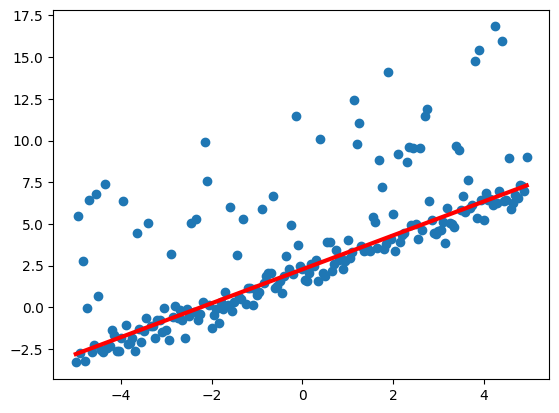

In [43]:
import matplotlib.pyplot as plt

alpha =  hr.intercept_
beta = hr.coef_[0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

## Polinomial Regression

In [44]:
import numpy as np

X = np.arange(-5, 5, 0.05)

nb_samples = len(X)

Y = X**2 + 2
Y += np.random.normal(0.0, 0.5, size=nb_samples)

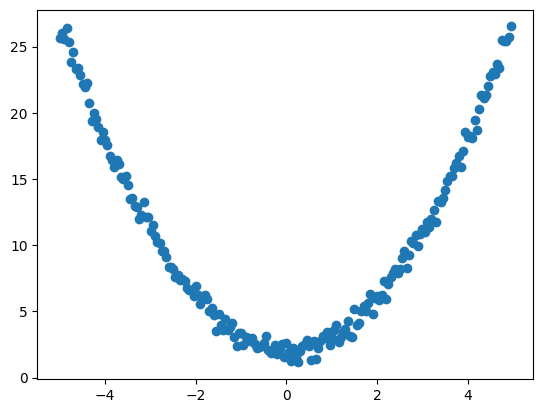

In [45]:
import matplotlib.pyplot as plt

plt.scatter(X, Y)
plt.show()

In [46]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X.reshape((-1, 1)), Y.reshape((-1, 1)))

print(lr.score(X.reshape((-1, 1)), Y.reshape((-1, 1))))

print(lr.intercept_)
print(lr.coef_)

0.0003598865091609671
[10.37207471]
[[-0.04882425]]


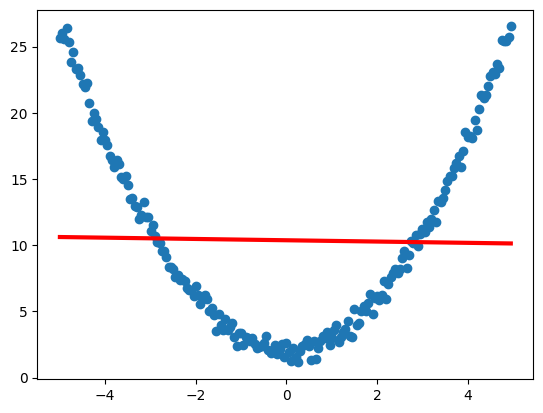

In [47]:
import matplotlib.pyplot as plt

alpha =  lr.intercept_
beta = lr.coef_[0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

In [48]:
def predictYpolinomial(X, alpha, beta):
    Ym = []
    print(len(beta))
    for i in range(len(X)):
        y = alpha
        for c in range(1, len(beta)):
            y += beta[c] * (X[i]**c)
        Ym.append(y)

    return Ym

In [49]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
Xp = pf.fit_transform(X.reshape(-1, 1))

lr.fit(Xp, Y.reshape((-1, 1)))

print(lr.score(Xp, Y.reshape((-1, 1))))
print(lr.intercept_)
print(lr.coef_)

0.9957773459451733
[2.08506049]
[[0.00000000e+00 9.02808910e-04 9.94541161e-01]]


3


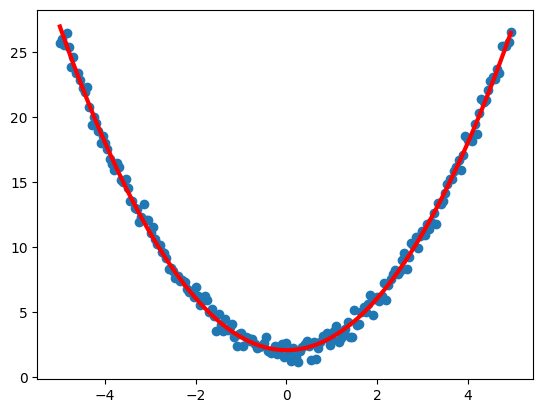

In [50]:
import matplotlib.pyplot as plt

alpha =  lr.intercept_[0]

Ym = predictYpolinomial(X, alpha, lr.coef_[0])

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

### Grau 3

In [51]:
import numpy as np

X = np.arange(-5, 5, 0.05)

nb_samples = len(X)

Y = 2*(X**3) + 0.5*(X**2) + X + 2
Y += np.random.normal(0.0, 0.5, size=nb_samples)

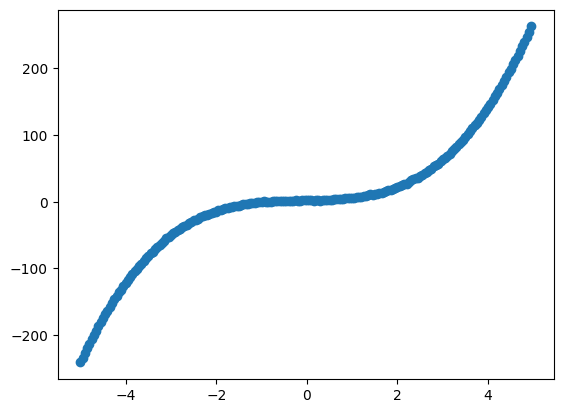

In [52]:
import matplotlib.pyplot as plt

plt.scatter(X, Y)
plt.show()

In [53]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X.reshape((-1, 1)), Y.reshape((-1, 1)))

print(lr.score(X.reshape((-1, 1)), Y.reshape((-1, 1))))

print(lr.intercept_)
print(lr.coef_)

0.8477178468427241
[5.62321732]
[[30.99103978]]


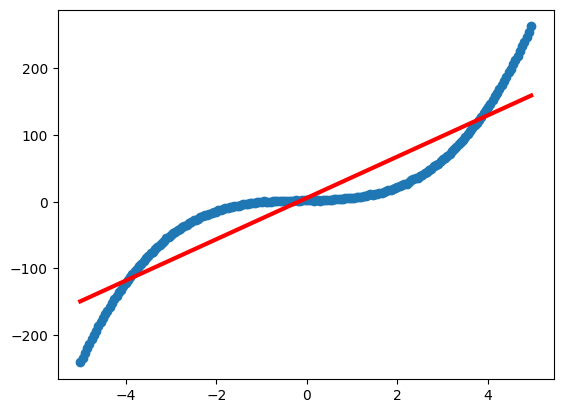

In [54]:
import matplotlib.pyplot as plt

alpha =  lr.intercept_
beta = lr.coef_[0]

Ym = predictY(X, alpha, beta)

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

In [55]:
from sklearn.metrics import r2_score

r2 = r2_score(Y,Ym)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.8477178468427241


In [56]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=3)
Xp = pf.fit_transform(X.reshape(-1, 1))

lr.fit(Xp, Y.reshape((-1, 1)))

print(lr.score(Xp, Y.reshape((-1, 1))))
print(lr.intercept_)
print(lr.coef_)

0.999970122529073
[1.89193636]
[[0.         0.99059921 0.50784616 2.00158875]]


4


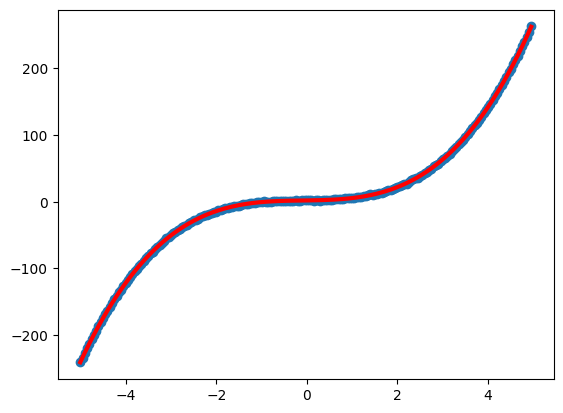

In [57]:
import matplotlib.pyplot as plt

alpha =  lr.intercept_[0]

Ym = predictYpolinomial(X, alpha, lr.coef_[0])

plt.scatter(X, Y)
plt.plot(X, Ym, color="red", linewidth=3)
plt.show()

In [58]:
from sklearn.metrics import r2_score

r2 = r2_score(Y,Ym)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.999970122529073


### e a base boston housing?

In [59]:
from sklearn.feature_selection import SelectFromModel

pf = PolynomialFeatures(degree=2)
Xp = pf.fit_transform(boston["data"])

print(Xp.shape)

lr = LinearRegression()
lr.fit(Xp, boston["target"])
print(lr.score(Xp, boston["target"]))

(506, 105)
0.9239966560996101


In [60]:
sm = SelectFromModel(lr, threshold=10)
Xt = sm.fit_transform(Xp, boston["target"])

print(sm.estimator_.score(Xp, boston["target"]))
print(Xt.shape)


0.9239966560996101
(506, 9)


In [61]:
Xo = sm.inverse_transform(Xt)
print(Xo.shape)

(506, 105)


## Modelo Não-Linear


In [62]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

X = np.linspace(0, 4, 50)
Y = func(X, 2.5, 1.3, 0.5)

rng = np.random.default_rng()

Y_noise = 0.2 * rng.normal(size=X.size)

Y = Y + Y_noise

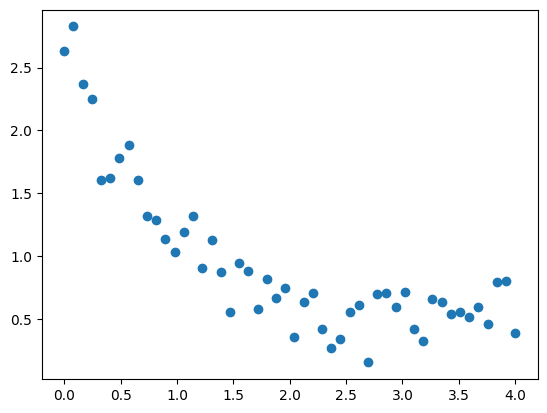

In [63]:
popt, pcov = curve_fit(func, X, Y)

plt.scatter(X, Y)
plt.show()

[2.2956626  1.3018186  0.49419126]
[[ 0.01182762  0.0052939  -0.00063664]
 [ 0.0052939   0.01795132  0.00471287]
 [-0.00063664  0.00471287  0.00230958]]


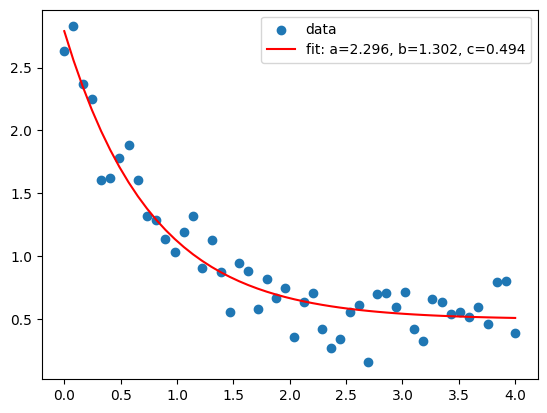

In [64]:
popt, pcov = curve_fit(func, X, Y)
print(popt)
print(pcov)

Ym = func(X, *popt)
plt.scatter(X, Y,  label='data')
plt.plot(X, Ym, 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import r2_score
r2 = r2_score(Y,Ym)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9161222527462418


[2.20919225 1.         0.39322122]
[[ 0.01133176  0.00239037 -0.00166392]
 [ 0.00239037  0.01520288  0.00689524]
 [-0.00166392  0.00689524  0.00458155]]


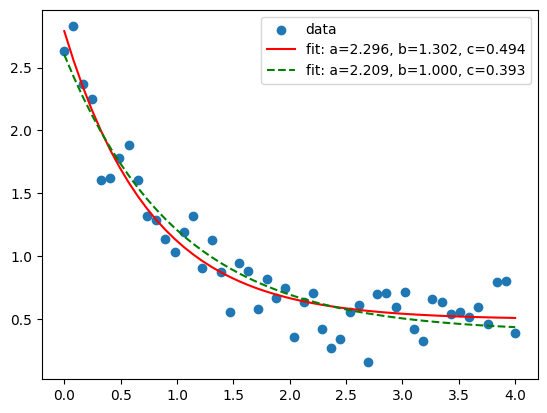

In [66]:
popt2, pcov2 = curve_fit(func, X, Y, bounds=(0, [3., 1., 0.5]))
print(popt2)
print(pcov2)

Ym = func(X, *popt)
Ym2 = func(X, *popt2)

plt.scatter(X, Y,  label='data')
plt.plot(X, Ym, 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(X, Ym2, 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt2))
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import r2_score
r2 = r2_score(Y,Ym2)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9045626522239508
